# Change runtime type to R

Remember, the first step when opening a Google Colab notebook is to change the runtime type to R from Python. Our code will not work otherwise!

# Install and load the packages

We will need to install two packages today
- `easystats` as usual
- `interactions` will help facilitate creating simple slope visualizations

Today we will load three packages:
- `tidyverse` (loads ggplot2, dplyr, readr, and other packages)
- `easystats` for helpful regression and model comparison functions
- `interactions` to create simple slopes visualizations


In [ ]:
## Install easystats package
install.packages(c("easystats", "interactions"))

In [75]:
## Load packages
library(easystats)
library(interactions)
library(tidyverse)

# Load the data

These data are artificially created to illustrate our points today. All variables are continuous:

1) (DV: GPA) The grade point average of the hypothetical students

2) (IV: IQ) The IQ score of the hypothetical students

3) (IV: Motivation) The motivation score for the hypothetical students

In [6]:
## Select a seed to reproduce the data created in the following lines of code
set.seed(211)

## The number of observations per variable to include, here its 250
n <- 250

## Draw data randomly from a normal distribution with mean of 2.75 and SD of .75
X <- rnorm(n, 2.75, .75) %>% round(0)

## Draw from a normal distribution of IQ scores with a mean of 100 and SD of 15
Z <- rnorm(n, 100, 15)

## Create a regression equation to relate these variables to an outcome Y
## Add random (normally-distributed) noise to each observation
Y <- .7 * X + .01 * Z + 2.5 * X * Z + rnorm(n, sd = 5)

## Convert the GPA outcome variable to range between 0 and 4
Y <- (Y - min(Y)) / (max(Y) - min(Y)) * 4

## Include all variables into one data object
GPA <- data.frame(GPA = Y, Motivation = X, IQ = Z)

## Show the dataset
head(GPA, n = 10)

,GPA,Motivation,IQ
,<dbl>,<dbl>,<dbl>
1,0.638353024,2,88.60718
2,2.129844991,4,94.26360
3,0.842032086,2,103.60064
4,0.008486496,1,93.89426
5,1.788104526,3,110.98725
6,0.878997002,2,103.56174
7,1.147946246,3,80.23753
8,0.830213314,2,99.85366
9,1.306645826,3,88.49550


## Data cleaning: Standardization

Let's see how to implement a new form of data cleaning: Standardizing the variables. In other words, convert each continuous variable to be in z-score form. Recall that the steps to transform a variable into standard/z-score form, we have two conceptual steps:

1) Subtract the variable mean from each observation of that variable. If we subtract the mean from each variable, the new variable is in "deviation score form" because each value is the difference (deviation) from the mean value. This variable has a new average of 0 (we "took away" the mean).

2) Divide the mean-centered observations from step #1 above by the variable's standard deviation.


In [14]:
## Step 1: Create mean deviation scores (subtract mean from each value)
GPA_Standardized <- GPA %>%
  mutate(Deviation    = GPA - mean(GPA),
         Standardized = Deviation / sd(GPA))

## Show the GPA, deviation scores,and standardized GPA scores
GPA_Standardized %>%
  select(GPA, Deviation, Standardized) %>%
  head(n = 10)

,GPA,Deviation,Standardized
,<dbl>,<dbl>,<dbl>
1,0.638353024,-0.70483519,-1.04724679
2,2.129844991,0.78665678,1.16881763
3,0.842032086,-0.50115612,-0.74461967
4,0.008486496,-1.33470171,-1.98310487
5,1.788104526,0.44491632,0.66105835
6,0.878997002,-0.46419121,-0.68969706
7,1.147946246,-0.19524196,-0.29009125
8,0.830213314,-0.51297490,-0.76218005
9,1.306645826,-0.03654238,-0.05429481


Remember that z-score variables have a mean of 0 and SD of 1? Both of these are a consequence of our z-score formula. Creating deviation scores (subtracting the mean) transforms the mean to be zero but does not change the variability. In other words, deviation scores are mean-shifted scores. Dividing by the standard deviation is what changes the variability to be 1.0.

In [27]:
## Show the summary statistics for these three variables
GPA_Standardized %>%
  select(GPA, Deviation, Standardized) %>%
  describe_distribution() %>%
  select(Variable, Mean, SD) %>%
  mutate(across(-Variable, ~ round(.x, 5)))

Variable,Mean,SD
<chr>,<dbl>,<dbl>
GPA,1.34319,0.67304
Deviation,0.00000,0.67304
Standardized,0.00000,1.00000


Like most things in R, there are multiple ways we can accomplish this task. The first object below shows two methods for achieving z-score data (i.e., standardizing).

Method 1 uses the formula inside mutate to subtract observations from the mean then divide by the standard deviation.
This can also be accomplished using the scale() function in R.

In [31]:
## Show two identical methods to standardize variables in R
GPAZScore <-
  GPA %>%
  mutate(GPAz1 = (GPA - mean(GPA)) / sd(GPA),
         GPAz2 = scale(GPA, center = TRUE, scale = TRUE))

## Ensure the two methods are exactly equivalent
GPAZScore %>%
  select(GPA, GPAz1, GPAz2) %>%
  round(5) %>%
  head()

## Create new variables which are z-score form of the raw variables
GPAClean <-
  GPA %>%
  mutate(GPAz   = scale(GPA,        center = TRUE, scale = TRUE),
         IQz    = scale(IQ,         center = TRUE, scale = TRUE),
         Motivz = scale(Motivation, center = TRUE, scale = TRUE))

,GPA,GPAz1,GPAz2
,<dbl>,<dbl>,"<dbl[,1]>"
1,0.63835,-1.04725,-1.04725
2,2.12984,1.16882,1.16882
3,0.84203,-0.74462,-0.74462
4,0.00849,-1.98310,-1.98310
5,1.78810,0.66106,0.66106
6,0.87900,-0.68970,-0.68970


# Regression with standardized variables

When all the continuous variables are standardized, the intercept term should be removed. To accomplish this in the `lm()` regression formula syntax, we merely insert a minus 1 into the formula. That tells R we do *not* want an intercept term to be estimated.  

In [38]:
## Estimate a main effects regression model
MainEffMod <- lm(formula = GPAz ~ -1 + IQz + Motivz, data = GPAClean)

## Extract the estimated model coefficients
parameters(MainEffMod) %>%
  mutate(across(-Parameter, ~ round(.x, 3)))

Parameter,Coefficient,SE,CI,CI_low,CI_high,t,df_error,p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IQz,0.446,0.008,0.95,0.430,0.463,53.940,248,0
Motivz,0.875,0.008,0.95,0.859,0.891,105.762,248,0


The main effects only model is represented by the following equation:

$\hat{GPA} = 0.446 \cdot IQ + 0.875 \cdot Motivation$

## Forgetting to remove the intercept term

In the example below, I omitted the "-1" term in the regression syntax. R will therefore estimate the intercept term, which is *functionally* zero. Notice that the intercept term is 4.9e-17? That is scientific notation for 0.000000000000000049 (i.e., functionally zero).

In [39]:
## Estimate a main effects regression model
MainEffModInt <- lm(formula = GPAz ~ IQz + Motivz, data = GPAClean)

## Extract the estimated model coefficients
parameters(MainEffModInt)

Parameter,Coefficient,SE,CI,CI_low,CI_high,t,df_error,p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
(Intercept),4.942329e-17,0.008272345,0.95,-0.01629333,0.01629333,5.974520e-15,247,1.000000e+00
IQz,4.463195e-01,0.008291140,0.95,0.42998917,0.46264988,5.383090e+01,247,1.856465e-138
Motivz,8.751186e-01,0.008291140,0.95,0.85878828,0.89144898,1.055486e+02,247,1.733654e-207


## Interaction model

We can also estimate the full regression model with the interaction between IQ and Motivation as well. This is no different from before, we separate the important variables with an asterisks, which automatically includes the main effects and interactions for the specified variables.

In [41]:
## Estimate an interaction effects regression model
InteractMod <- lm(formula = GPAz ~ -1 + IQz * Motivz, data = GPAClean)

## Extract the estimated model coefficients
parameters(InteractMod) %>%
  mutate(across(-Parameter, ~ round(.x, 3)))

Parameter,Coefficient,SE,CI,CI_low,CI_high,t,df_error,p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IQz,0.433,0.001,0.95,0.430,0.436,296.407,247,0
Motivz,0.872,0.001,0.95,0.869,0.874,600.178,247,0
IQz:Motivz,0.124,0.001,0.95,0.122,0.127,88.374,247,0


The interaction effects model is represented by the following equation:

$\hat{GPA} = 0.433 \cdot IQ + 0.872 \cdot Motivation + 0.124 \cdot IQ \cdot Motivation$

## Return both model results at once

Because we have estimated nested regression models, we can use the compare_models() function from the easystats package to return the results of each model. This simplifies the side-by-side comparison.

**Why are the models nested?**

The interaction-effect model has 3 parameters (i.e., 2 main effects & 1 interaction effect). The main-effect model includes the 2 main effects and no parameters beyond those included in the interaction-effects model. Therefore, the main-effect model is nested *within* the interaction-effect model.

In [44]:
## Compare the model results from the nested models
compare_models(MainEffMod, InteractMod) %>% t()

,1,2,3
Parameter,IQz,Motivz,IQz × Motivz
Component,conditional,conditional,conditional
Effects,fixed,fixed,fixed
Coefficient.MainEffMod,0.4463195,0.8751186,NA
SE.MainEffMod,0.008274407,0.008274407,NA
CI.MainEffMod,0.95,0.95,NA
CI_low.MainEffMod,0.4300225,0.8588216,NA
CI_high.MainEffMod,0.4626166,0.8914157,NA
t.MainEffMod,53.93976,105.76209,NA
df_error.MainEffMod,248,248,NA


There is much output here but the main elements to focus on are "coefficient" prefixes. For example, the IQz slope term is 0.446 for the main-effects model but 0.433 for the interaction-effect model. Although the differences are small here, they can become very large in some data contexts!

# Evaluating models

The coefficient of determination (i.e., $R^2$) represents the "proportion of variability in the outcome/DV that is explained by optimally combining the predictors/IVs". Higher values mean a model "fits" the data better, meaning that predicted scores are very close to the actual scores.

This value is very easy to obtain from a regression model, we merely use the r2() function on the regression model (i.e., the object resulting from the `lm()` function).

The $R^2$ value is also obtainable from other sources, such as the `summary()` function applied to the results of the `lm()` function output.

In [45]:
## Return the coefficient of determination for the main effects model
r2(MainEffMod)

## Return the coefficient of determination for the interaction model
r2(InteractMod)

# R2 for Linear Regression
       R2: 0.983
  adj. R2: 0.983

# R2 for Linear Regression
       R2: 0.999
  adj. R2: 0.999

A more general function to compare multiple models (using multiple statistics) is the `compare_performance()` function. Merely include the objects associated with the estimated regression models and several statistics to compare the models are provided. Notably for us, we see the $R^2$ (coefficient of determination) score.


In [46]:
## Return the model fit statistics for both models simultaneously
compare_performance(MainEffMod, InteractMod)

Name,Model,AIC,AIC_wt,AICc,AICc_wt,BIC,BIC_wt,R2,R2_adjusted,RMSE,Sigma
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MainEffMod,lm,-304.6023,1.779364e-189,-304.5047,1.838791e-189,-294.0379,1.035e-188,0.9830295,0.9828926,0.1300101,0.13053329
InteractMod,lm,-1173.8269,1.000000e+00,-1173.6636,1.000000e+00,-1159.7411,1.000e+00,0.9994797,0.9994734,0.0227636,0.02290143


Each of the columns from AIC to Sigma are different approaches to comparing models. For simplicity, we will focus on $R^2$ and we should also consider the $R^2_{adjusted}$ term, too.

## Model comparison

To determine the change in the coefficient of determination, we merely subtract the "small" model from the "big" model. The "big" model (i.e., the model with more parameters being estimated) is more complex and is guaranteed to have a larger $R^2$ value
compared to the smaller model (i.e., the model nested within the larger model).

Above, the $R^2$ value for the main effects model is 0.983 and is 0.999 for the interaction effects model. Therefore, the $\Delta R^2$ value is $.999 - .983 = 0.016$

This $\Delta R^2$ term is equivalent to saying the interaction-effect model helps explain another 1.6% of the variance in the GPA variable than the main-effect model alone.

# Simple slopes

Creating a graph with simple slopes is not super easy. We won't focus too much on creating simple slopes but the code to implement as such is provided here.

Let's do two versions, one where we hold IQ constant at specific intervals and another where we hold Motivation constant at specific intervals.

To hold IQ constant, we are going to see the line-of-best-fit when IQ is at values of -2, -1, 0, 1, or 2. Notice that these are still in z-score form so they are in standard deviation units from the mean.  

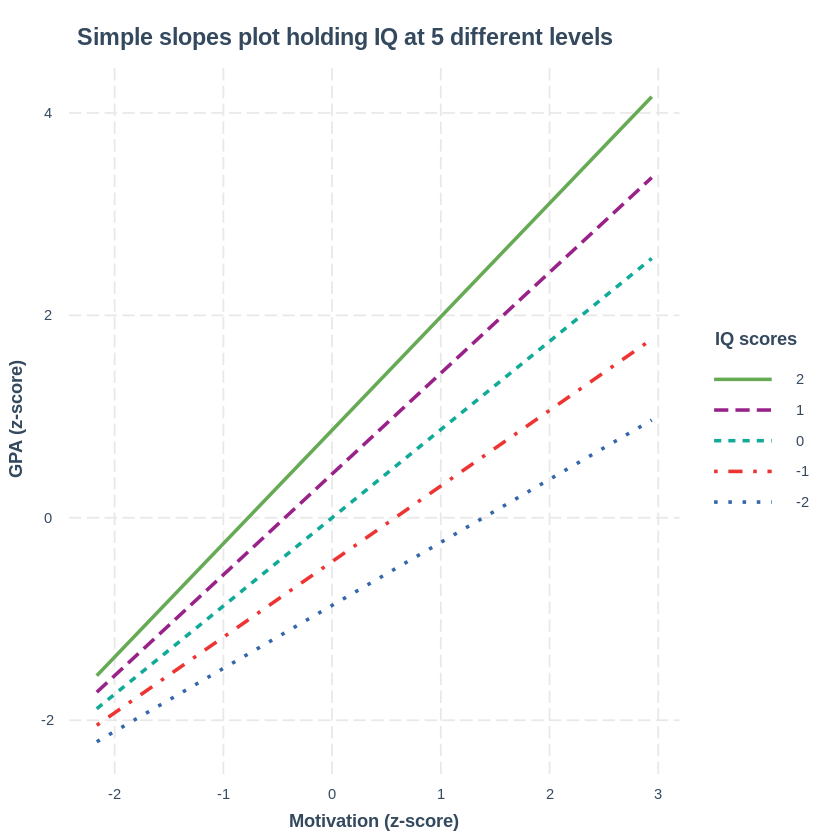

In [84]:
## Estimate the interaction effects model without an intercept
Mod1 <- lm(GPAz ~ -1 + IQz * Motivz, data = GPAClean)

## Create a plot of simple slopes by specifying levels of IQz
interact_plot(Mod1,
              pred        = "Motivz",
              modx        = "IQz",
              modx.values = c(-2, -1, 0, 1, 2),
              x.label     = "Motivation (z-score)",
              y.label     = "GPA (z-score)",
              legend.main = "IQ (z-score)",
              colors      = "Qual1",
              main.title  = "Simple slopes plot holding IQ at 5 different levels")

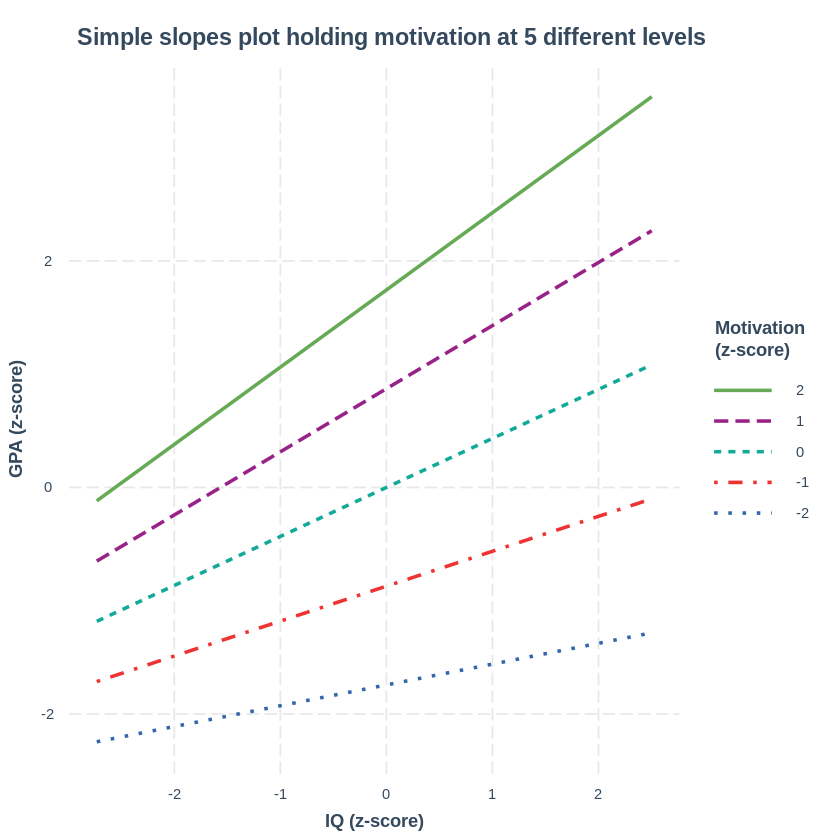

In [85]:
## Create a plot of simple slopes by specifying levels of Motivz
interact_plot(Mod1,
              pred        = "IQz",
              modx        = "Motivz",
              modx.values = c(-2, -1, 0, 1, 2),
              x.label     = "IQ (z-score)",
              y.label     = "GPA (z-score)",
              legend.main = "Motivation \n(z-score)",
              colors      = "Qual1",
              main.title  = "Simple slopes plot holding motivation at 5 different levels")

## Interpreting simple slopes

Let's look at the last graph. When motivation is low (i.e., -2 represents 2 standard deviation units lower than the average motivation), the relationship between IQ and GPA is weaker but more IQ is still related to higher GPAs. When motivation is high (i.e., 2 standard deviation units *above* the average), there is a very strong IQ-GPA relationship. These people with high IQs have high motivation and therefore have very high GPAs.